In [120]:
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from keras.preprocessing import sequence
from sklearn.model_selection import train_test_split

# fix random seed for reproducibility
np.random.seed(7)

In [110]:
dataset = 'drive/MyDrive/ClassifySequence/gestures_test_seq.csv'
model_save_path = 'gesture_sequence_classifier_test.hdf5'

In [229]:
x = []
labels = []
NORMALIZE = False
with open(dataset) as f:
    lines = f.readlines()
    for line in lines:
        spl = line.split(" | ")
        labels.append(int(spl[0][:-1]))
        coords_seq = np.array(list(map(lambda x: np.array(x), map(eval, spl[1:]))))
        if NORMALIZE:
          for coords in coords_seq:
            first_x = coords[0]
            first_y = coords[1]
            coords[0::2] -= first_x
            coords[1::2] -= first_y
        x.append(coords_seq)
x = np.array(x, dtype=object)
labels = np.array(labels, dtype='int32')
labels[:10], x.shape
# длина координат в каждом из x должна быть кратна 42 (21 точек по икс + 21 точек по игрек)
# формат [x1 y1 x2 y2 x3 y3 ...]

(array([8, 8, 8, 8, 8, 8, 8, 8, 8, 8], dtype=int32), (98,))

Проверка координат (графически и по указательному пальцу)

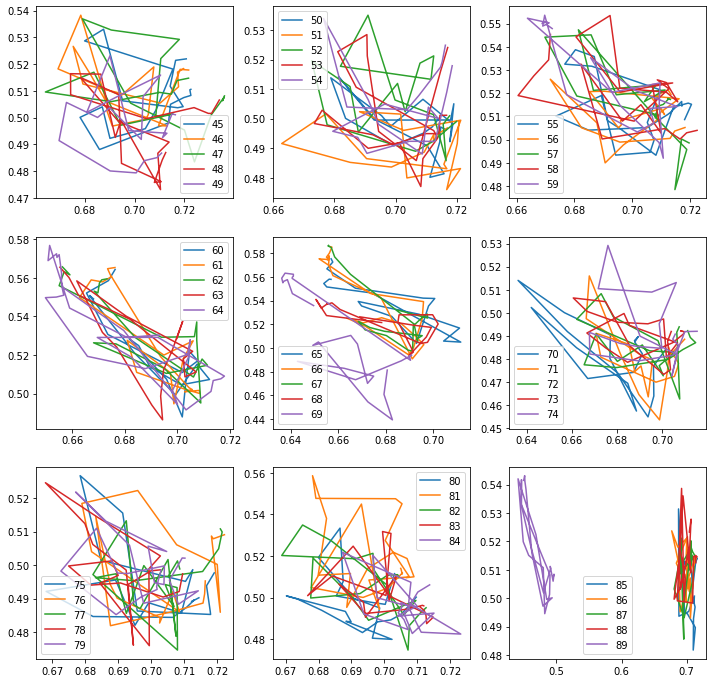

In [234]:
FROM =  45#@param {type:"number"}
TO =  90#@param {type:"number"}
ranges = [range(a, a + 5) for a in range(FROM, TO, 5)]
subplots_nums = [331, 332, 333, 334, 335, 336, 337, 338, 339]

tips_x = []
tips_y = []
point_num = 4
for a in x:
  finger_tip_coords_x = list(map(lambda x: x[point_num * 2], a))
  finger_tip_coords_y = list(map(lambda x: x[point_num * 2 + 1], a))
  tips_x.append(finger_tip_coords_x)
  tips_y.append(finger_tip_coords_y)

plt.figure(figsize=(12, 12))
for rng, subplot_num in zip(ranges, subplots_nums):
  plt.subplot(subplot_num)
  for i in rng:
    plt.plot(tips_x[i], tips_y[i])
  plt.legend(list(map(str, list(rng))), loc='best')
plt.show()
# 

In [149]:
max_len = max(list(map(lambda x: x.shape[0], x)))
max_len

61

In [113]:
padded_x = sequence.pad_sequences(x, maxlen=max_len, dtype='float', padding='post')
padded_x[0]

array([[ 0.        ,  0.        , -0.04548681, ..., -0.23034719,
        -0.03563762, -0.18770203],
       [ 0.        ,  0.        , -0.04579765, ..., -0.23291418,
        -0.03681362, -0.1909667 ],
       [ 0.        ,  0.        , -0.04610032, ..., -0.2301237 ,
        -0.03760439, -0.18755919],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [148]:
NUM_CLASSES = len(set(labels))
min_label = min(labels)
labels -= min_label
NUM_CLASSES, labels[:10]

(2, array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32))

In [115]:
X_train, X_test, Y_train, Y_test = train_test_split(padded_x, labels, test_size=0.25, random_state=42, shuffle=True)
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((63, 61, 42), (21, 61, 42), (63,), (21,))

In [116]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input(X_train[0].shape),
    tf.keras.layers.LSTM(100),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 100)               57200     
                                                                 
 dropout_15 (Dropout)        (None, 100)               0         
                                                                 
 dense_16 (Dense)            (None, 2)                 202       
                                                                 
Total params: 57,402
Trainable params: 57,402
Non-trainable params: 0
_________________________________________________________________


In [117]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False
)
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [119]:
begin = datetime.now()
history = model.fit(
    X_train,
    Y_train,
    epochs=100,
    batch_size=128,
    validation_data=(X_test, Y_test),
    callbacks=[cp_callback, es_callback]
)
end = datetime.now()

Epoch 1/100
1/1 [==============================] - ETA: 0s - loss: 1.5122e-05 - accuracy: 1.0000
Epoch 1: saving model to gesture_sequence_classifier_test.hdf5
1/1 [==============================] - 0s 205ms/step - loss: 1.5122e-05 - accuracy: 1.0000 - val_loss: 1.1030e-05 - val_accuracy: 1.0000
Epoch 2/100
1/1 [==============================] - ETA: 0s - loss: 1.6570e-05 - accuracy: 1.0000
Epoch 2: saving model to gesture_sequence_classifier_test.hdf5
1/1 [==============================] - 0s 256ms/step - loss: 1.6570e-05 - accuracy: 1.0000 - val_loss: 1.1018e-05 - val_accuracy: 1.0000
Epoch 3/100
1/1 [==============================] - ETA: 0s - loss: 1.4933e-05 - accuracy: 1.0000
Epoch 3: saving model to gesture_sequence_classifier_test.hdf5
1/1 [==============================] - 0s 224ms/step - loss: 1.4933e-05 - accuracy: 1.0000 - val_loss: 1.1001e-05 - val_accuracy: 1.0000
Epoch 4/100
1/1 [==============================] - ETA: 0s - loss: 1.1930e-05 - accuracy: 1.0000
Epoch 4: sav

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


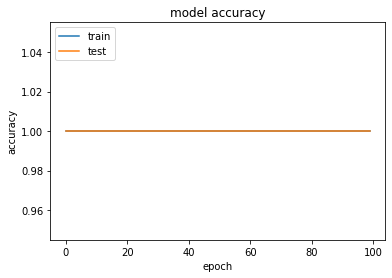

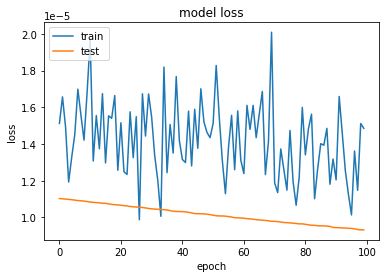

In [121]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()